# **Open Circuit Potential (OCP) Balancing**

This notebook is created to provide an example of using PyBaMM-param package when balancing OCP curve with shifting and stretching the fitted curve to experimental data. This can also be found in `scripts/ocp_balance.py` as Python function.

In [1]:
#%pip install git+https://github.com/paramm-team/pybamm-param.git -q
import pbparam
import pandas as pd
import os

os.chdir(os.path.join(pbparam.__path__[0], "input", "data"))

We have 4 different files in this example. 2 for half-cell and 2 for three-electrode full cell. They are divided for their lithiation and delithiation stage.

In [2]:
#  .csv files are uploaded
anode_half_lit = pd.read_csv(os.path.join("anode_OCP_2_lit.csv"))
anode_half_delit = pd.read_csv(os.path.join("anode_OCP_2_delit.csv"))
anode_three_lit = pd.read_csv(os.path.join("anode_OCP_3_lit.csv"))
anode_three_delit = pd.read_csv(os.path.join("anode_OCP_3_delit.csv"))

In [3]:
#  .csv files are uploaded
cathode_half_lit = pd.read_csv(os.path.join("cathode_OCP_2_lit.csv"))
cathode_half_delit = pd.read_csv(os.path.join("cathode_OCP_2_delit.csv"))
cathode_three_lit = pd.read_csv(os.path.join("cathode_OCP_3_lit.csv"))
cathode_three_delit = pd.read_csv(os.path.join("cathode_OCP_3_delit.csv"))

Then, optimisation problem should be passed to pbparam with the data to be used as below. Cost function (default=pbparam.RMSE()) and weights (default=[1,1]) are optional arguments. Weights can be defined as single value list or same lengt with data.

In [4]:
ocp_balance_cathode = pbparam.OCPBalance(
    [cathode_half_lit, cathode_half_delit],
    [cathode_three_lit, cathode_three_delit],
    
    #cost_function=pbparam.MLE(),
    #weights=[2],
)
ocp_balance_cathode.bounds

Q_V_max is  0.317798093756079
Q_V_min is  1.0


[(-0.5124258667883221, 1.1), (-0.1, 1.612425866788322)]

In [5]:
ocp_balance_anode = pbparam.OCPBalance(
    [anode_half_lit, anode_half_delit],
    [anode_three_lit, anode_three_delit],
    
    #cost_function=pbparam.MLE(),
    #weights=[2],
)
ocp_balance_anode.bounds

Q_V_max is  0.0
Q_V_min is  1.0


[(-1e-06, 1.1), (-0.1, 1.1)]

Optimiser to minimise cost function should be selected in the nest step as below.

In [6]:
optimiser = pbparam.ScipyMinimize(method="Nelder-Mead")

# optimiser = pbparam.ScipyDifferentialEvolution(
#     extra_options={"workers": 4, "polish": True, "updating": "deferred", "disp": True})

In [7]:
ocp_balance_cathode.bounds = [(None,None),(None, None)]
ocp_balance_anode.bounds = [(None,None),(None, None)]

```optimiser.optimise(optimisation_problem)``` should be used to run minimasiation algorithm.

In [8]:
result_anode = optimiser.optimise(ocp_balance_anode)
result_cathode = optimiser.optimise(ocp_balance_cathode)

shift and stretch values and final cost function value can be printed as below.

In [9]:
print("Anode Results: ",result_anode)
print("Cathode Results: ",result_cathode)

Anode Results:  
             Optimal values: [-0.02485258  4.85725982]
        Cost function value: 0.5994784773969779
                 Solve time: 118.401 ms
                    Message: Optimization terminated successfully.
        
Cathode Results:  
             Optimal values: [ 6.78447775 -7.09746344]
        Cost function value: 0.003170116930492252
                 Solve time: 163.590 ms
                    Message: Optimization terminated successfully.
        


PyBaMM-param has built in plot function to represent results.

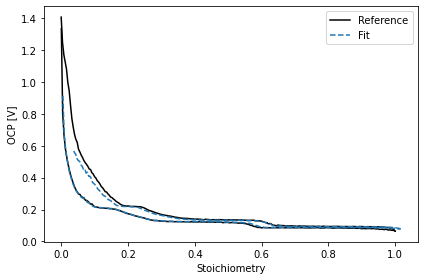

In [10]:
result_anode.plot();

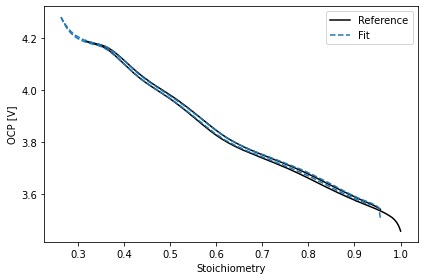

In [11]:
result_cathode.plot();